A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [2]:
import sys
from tqdm.autonotebook import tqdm
sys.version

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

/Users/andrey/miniconda3/envs/spoton/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import lmfit

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

import fastspt as fs
from fastspt import fit, tools, plot, readers, matimport, tracklen
%load_ext autoreload

%autoreload 2

print("Using fastspt version {}".format(fs.__version__))

import logging
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

Using fastspt version 16.4


In [4]:
import os
os.getcwd()

'/Users/andrey/Documents/Spot-On-Cli'

In [5]:
from glob import glob
import scipy.io

In [8]:
folder = r"datasets/A22_treatment_rodZ/"
#folder = r"Z:\Andrey\data\2019\0403-RAMM-e-coli-pbp2-PAmCherry-TLK130\100x_1.49NA\0403_OD0.1"

data_paths = glob(folder + "*/*/*pathsC.mat") # *tracks.xml
print(len(data_paths))

20


In [9]:
data_paths

['datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf-pathsC.mat',
 'datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf_1-pathsC.mat',
 'datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf_2-pathsC.mat',
 'datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf_3-pathsC.mat',
 'datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-15s-tirf_1-pathsC.mat',
 'datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/05-09

In [20]:
# Independent experiments
reps = []
data_paths = data_paths[:]
for path in data_paths:
    print(path)
    # reps.append(readers.read_trackmate_xml(xml_path))
    xyft_table = scipy.io.loadmat(path)['paths'][:,:4]
    grouped_tracks = matimport.group_tracks(xyft_table, min_len=3, exposure_ms=60, pixel_size_um=0.08)
    reps.append(grouped_tracks)

datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf-pathsC.mat
3274  tracks 
datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf_1-pathsC.mat
2771  tracks 
datasets/A22_treatment_rodZ/Res0.2_Intpercentage_std3_MaxDisp4_rawth2/04-29-Mec000-RodZ-IPTG100-6h/04-29-Mec000-RodZ-IPTG100-6h_GFP-50mW-60msExp-FTo-bleaching-10s-tirf_2-pathsC.mat
3283  tracks 


In [15]:
reps[0]

[array([[23.18416504,  1.06000557,  0.12      ,  2.        ],
        [23.1767853 ,  1.05338514,  0.18      ,  3.        ],
        [23.2090878 ,  1.07483113,  0.24      ,  4.        ]]),
 array([[8.27675578, 1.09589143, 0.12      , 2.        ],
        [8.25812393, 1.12402206, 0.18      , 3.        ],
        [8.27801652, 1.11442784, 0.24      , 4.        ],
        [8.29035439, 1.10373211, 0.36      , 6.        ]]),
 array([[14.94031071,  1.30109342,  0.12      ,  2.        ],
        [14.96685723,  1.32681637,  0.18      ,  3.        ],
        [14.90059285,  1.30874508,  0.24      ,  4.        ],
        [14.95675703,  1.33903523,  0.3       ,  5.        ],
        [14.94679124,  1.35035609,  0.36      ,  6.        ],
        [14.95596384,  1.35564207,  0.42      ,  7.        ],
        [14.92427501,  1.33482292,  0.48      ,  8.        ],
        [14.9390112 ,  1.28366663,  0.54      ,  9.        ],
        [14.87629278,  1.3809529 ,  0.6       , 10.        ],
        [14.95312062

# 2. Track lengths analysis

3274 tracks, 21803 localizations
Fit result: 5246.31 * e^(-x/1.83) + 45.78


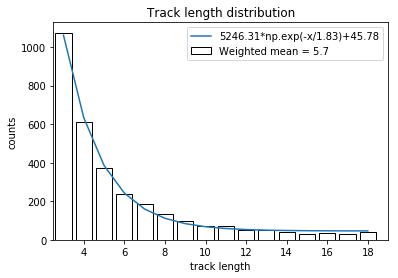

2771 tracks, 17856 localizations
Fit result: 5523.06 * e^(-x/1.69) + 35.02


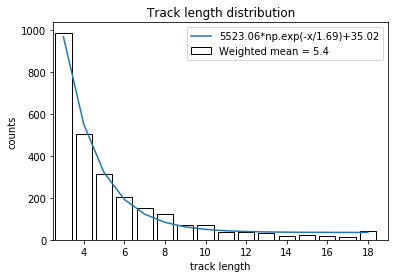

3283 tracks, 22683 localizations
Fit result: 4383.65 * e^(-x/1.98) + 42.99


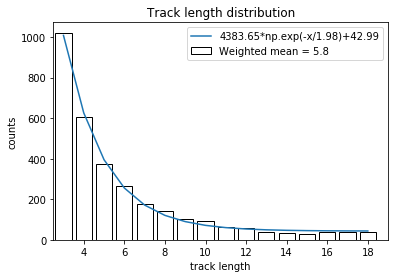

In [16]:
for rep in reps:
    tracklen.get_track_lengths_dist(rep, plot=True)

## 3. Fitting of the jump lengths distribution to the model (2 states)


DEBUG:fastspt.fit:useAllTraj = False
DEBUG:fastspt.fit:len(trackedPar) = 3274


Number of frames: 1000.0, number of localizations: 21803
Computation of jump lengths performed in 2.82s
Fitting 2 states
Improved fit on iteration 1
Improved error is 4.830807928845194e-06
Name        Value      Min      Max   Stderr
D_bound  0.0006458        0    0.005 2.258e-05
D_free    0.01238     0.01      0.1 0.0004096
F_bound    0.7145        0        1 0.005776
sigma     0.01909    0.005      0.1 0.0001239
None


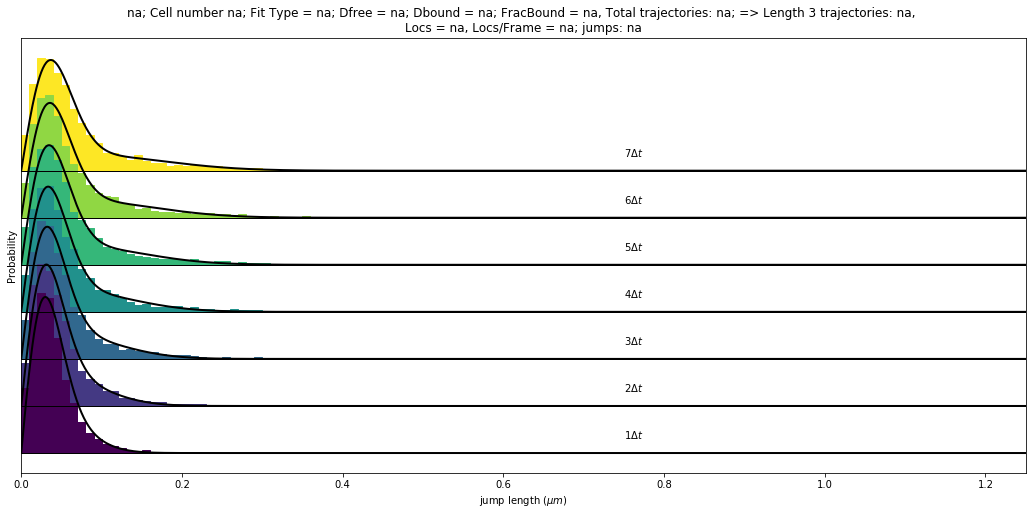

DEBUG:fastspt.fit:useAllTraj = False
DEBUG:fastspt.fit:len(trackedPar) = 2771


Number of frames: 1000.0, number of localizations: 17856
Computation of jump lengths performed in 2.86s
Fitting 2 states
Improved fit on iteration 1
Improved error is 5.223443133258332e-06
Name        Value      Min      Max   Stderr
D_bound  0.0004798        0    0.005 2.057e-05
D_free    0.01026     0.01      0.1 0.0004841
F_bound    0.7826        0        1 0.006533
sigma     0.01946    0.005      0.1 0.0001138
None


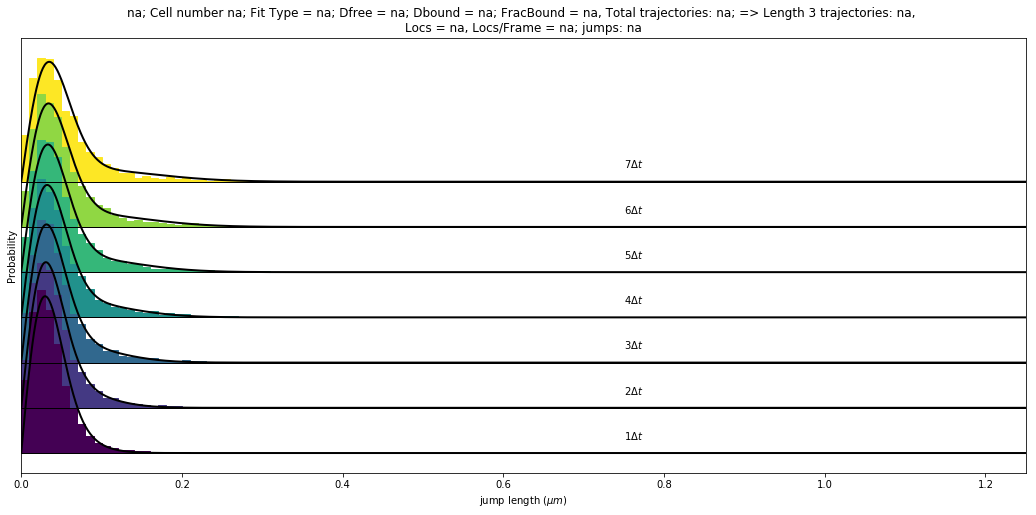

DEBUG:fastspt.fit:useAllTraj = False
DEBUG:fastspt.fit:len(trackedPar) = 3283


Number of frames: 1000.0, number of localizations: 22683
Computation of jump lengths performed in 2.91s
Fitting 2 states
Improved fit on iteration 1
Improved error is 6.121755297523231e-06
Name        Value      Min      Max   Stderr
D_bound  0.0006756        0    0.005 2.369e-05
D_free    0.01479     0.01      0.1 0.0004443
F_bound    0.6795        0        1 0.005317
sigma     0.01802    0.005      0.1 0.0001412
None


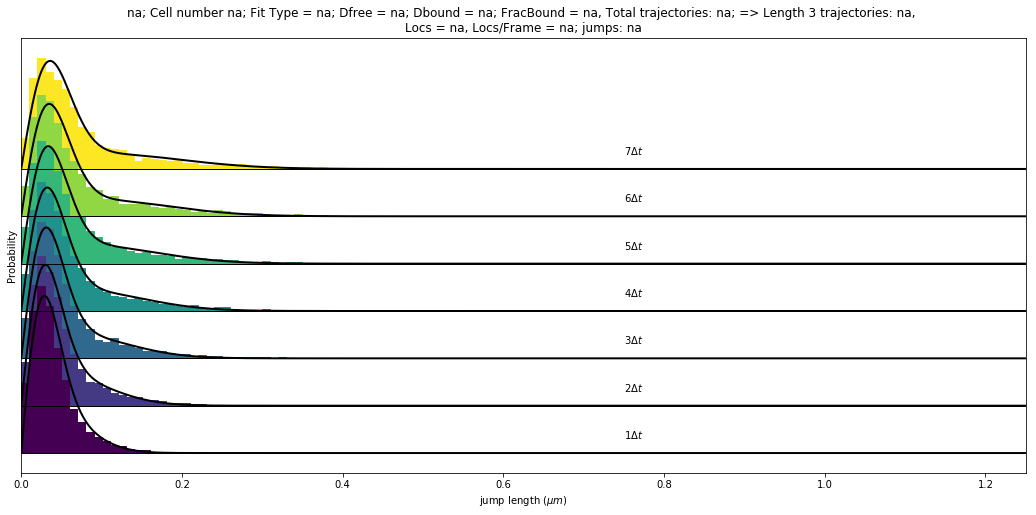

In [19]:
## Generate a dictionary of parameters
fit_params = dict(states=2,
                 iterations=1,
                 CDF=False,
                 CDF1 = True,
                 Frac_Bound = [0, 1],
                 D_Free = [0.01, 0.1],
                 D_Med = [0.005, 0.1],
                 D_Bound = [0.0, 0.005],
                 sigma = 0.02,
                 sigma_bound = [0.005, 0.1],
                 fit_sigma=True,
                 dT=0.06,
                 dZ=0.7,
                 a=0.15716,
                 b=0.20811,
                 useZcorr=False,
                 plot_hist=False,
                 plot_result=True) 


def my_fit(rep):
    
    cell_spt = readers.to_fastSPT(rep, from_json=False)
    fit_result = tools.auto_fit(cell_spt,
                                fit_params=fit_params)
    return fit_result

reps_fits = list(map(my_fit, reps))


In [37]:
#get stats
fit_stats = pd.DataFrame(columns=list(reps_fits[0].best_values.keys()) + ['chi2', 'num_tracks'])

for i, fit_result in enumerate(reps_fits):
    name = data_paths[i].split("/")[-2]
    # name = f'rep {i+1}'
    fit_stats.loc[f'{name}'] = list(fit_result.best_values.values()) + [fit_result.chisqr, len(reps[i])]

fit_stats.loc['mean'] = fit_stats.mean(axis=0)
fit_stats.loc['std'] = fit_stats.std(axis=0)

#fit_stats.to_json(folder + '\stats.json')

fit_stats
#fit_stats.to_excel(path_oe + '.stats.xls')

IndexError: list index out of range

In [19]:
# save stats

fit_stats.to_json(folder + '\stats.json')

In [97]:
# remove bad fits
stats_filtered = fit_stats[fit_stats.chi2 < 0.01]
stats_filtered.to_json(folder + '\stats_chi2_better_than_0.01.json')
stats_filtered

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
"['FOV1', 'movie_Ard_trig_v1.0_exp_60ms_561_50W_30ms_405_12.5mW_0.8ms_1']",0.061961,3.581161e-04,0.283051,0.047220,0.004957,1910.000000
"['FOV5', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.100000,7.438494e-17,0.235892,0.054208,0.005529,16449.000000
"['FOV7', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.068401,1.004699e-03,0.290912,0.049450,0.001203,9115.000000
mean,0.078304,3.407038e-04,0.366257,0.046612,0.007740,7115.500000
std,0.014634,4.102898e-04,0.168127,0.006856,0.006861,6240.106349


In [55]:
import json

In [58]:
json.dump(fit_params, open(folder + '\params.json', 'x'))

In [16]:
pd.read_json(r"Z:/Andrey/fromGizem/2019-04-18-PBP2-tracks/PBP2OverExpforAndrey.mat.stats.json",)

,D_fast,D_med,D_bound,F_fast,F_bound,sigma,chi2
mean,0.036449,0.011052,1.067581e-04,0.547984,0.123352,0.019759,0.001334
rep 1,0.036826,0.010664,1.053494e-04,0.521843,0.128585,0.019831,0.001504
rep 2,0.041200,0.015000,2.149249e-04,0.467069,0.124263,0.020219,0.001203
rep 3,0.031321,0.007492,7.549517e-17,0.655040,0.117209,0.019227,0.001295
std,0.004042,0.003078,8.774840e-05,0.078933,0.004689,0.000408,0.000126
